In [1]:
import sys
sys.path.append('../app/')

import preprocess
import featureprocess
import fileio
import evaluation
import numpy as np
import modelacc
import pandas as pd
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dfoff,dftest,dfon = fileio.read_all()

# 1、数据总览

In [3]:
dfoff.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN


In [4]:
dftest.head(2)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706


In [5]:
dfon.head(2)

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0


# 2、线下单特征测试

In [6]:
#dfoff :打标签;无券-1；有券且15天内消费1；其他0（包括有券不消费、有券15天后消费）
#dfall :标签！=-1
dfoff,dfall,train,valid = preprocess.preprocess(dfoff)

In [7]:
#留个档
dfori = dfall.copy()
dfori.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN,0
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,0
6,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0,0


In [8]:
#dfall特征处理
dfall = featureprocess.process_features_main(dfall)

In [9]:
dfall.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_rate,discount_man,discount_jian,discount_type,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,UM_id,用户id,只领券,核销数,直接买,单商铺最大购买次数,成交商家数
0,1439408,4663,11002.0,150:20,1,20160528.0,NaN,0,0.866667,150,20,1,6,1,0,0,0,0,0,1,0,1439408_4663,NaN,1.0,0.0,0.0,1.0,1.0
1,1439408,2632,8591.0,20:1,0,20160217.0,NaN,0,0.950000,20,1,1,3,0,0,0,1,0,0,0,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
2,1439408,2632,1078.0,20:1,0,20160319.0,NaN,0,0.950000,20,1,1,6,1,0,0,0,0,0,1,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
3,1439408,2632,8591.0,20:1,0,20160613.0,NaN,0,0.950000,20,1,1,1,0,1,0,0,0,0,0,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0
4,1439408,2632,8591.0,20:1,0,20160516.0,20160613.0,0,0.950000,20,1,1,1,0,1,0,0,0,0,0,0,1439408_2632,1439408_2632,2.0,0.0,0.0,2.0,1.0


## 2.1 discount_type
discount_type:空值为nan,冒号是1，其余是0  
discount_man\jian\rate  

<BarContainer object of 2 artists>

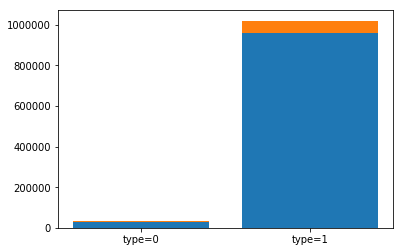

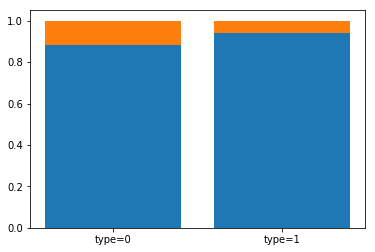

In [10]:
#不同子类，在label01或1的占比,xtype
xticks = ['type=0','type=1']
cc = dfall.groupby('discount_type')['label'].value_counts()
num_label_0 = cc.xs(0,level=1)
num_label_1 = cc.xs(1,level=1)

plt.bar(xticks,num_label_0)
plt.bar(xticks,num_label_1,bottom=num_label_0)


#
plt.figure()
a,b = cc.xs(0)/sum(cc.xs(0))
c,d = cc.xs(1)/sum(cc.xs(1))

xticks = ['type=0','type=1']
cc = dfall.groupby('discount_type')['label'].value_counts()
num_label_0 =a,c
num_label_1 =b,d
plt.bar(xticks,num_label_0)
plt.bar(xticks,num_label_1,bottom=num_label_0)

### type=0，有更多的人响应.主要差别在哪里？

In [224]:
def func1(dfall):
    si_vc = dfall.discount_rate.value_counts().sort_index()
    dfthis = pd.DataFrame(si_vc)
    cc2 = dfall.groupby('discount_rate')['label'].value_counts()
    dfthis.loc[:,'0'] = cc2.xs(0,level=1)
    dfthis.loc[:,'1'] = cc2.xs(1,level=1)
    dfthis.fillna(0,inplace=True)
    dfthis.index = np.around(dfthis.index,3)
    dfthis.index = dfthis.index.astype('str')
    return dfthis
def draw_func1(dfthis):
    plt.figure(figsize=(12,4))
    plt.bar(dfthis.index,dfthis.discount_rate,width=0.8)
    plt.xlim(0,1)
    plt.xticks(range(0,len(dfthis)),dfthis.index)
    
    plt.figure(figsize=(12,4))
    plt.bar(dfthis.index,dfthis['0']/dfthis.discount_rate,width=0.8)
    plt.bar(dfthis.index,dfthis['1']/dfthis.discount_rate,width=0.8,bottom=dfthis['0']/dfthis.discount_rate)
    plt.ylim(0,1.1)
    plt.xticks(dfthis.index);

Text(0.5, 1.0, 'discount_type=1')

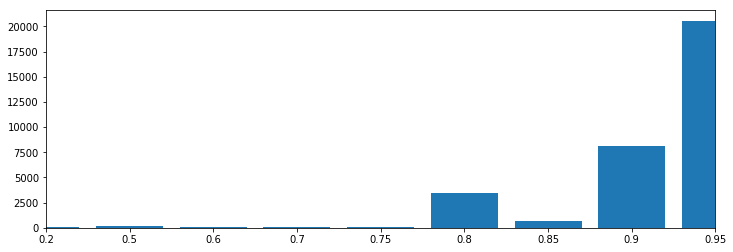

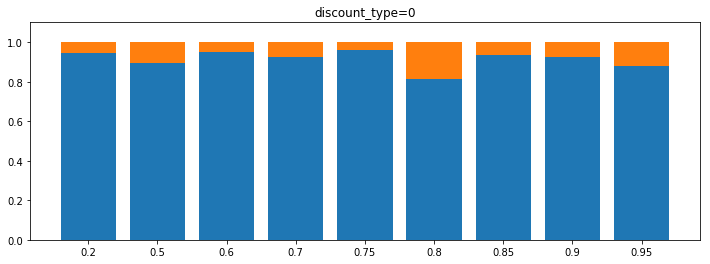

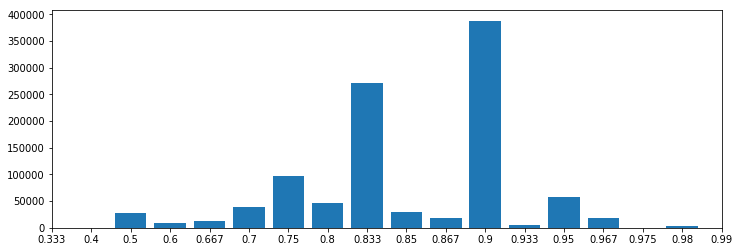

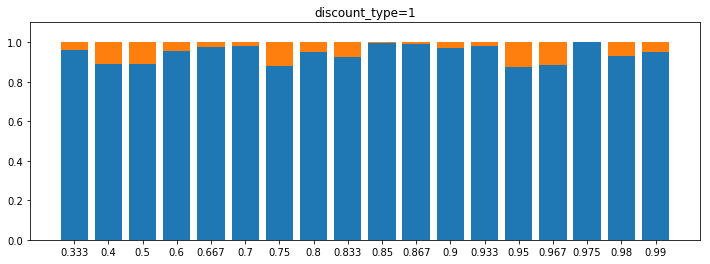

In [231]:
dfthis0 = func1( dfall[dfall['discount_type']==0] )
draw_func1(dfthis0)
plt.title('discount_type=0')

dfthis1 = func1( dfall[dfall['discount_type']==1] )
draw_func1(dfthis1)
plt.title('discount_type=1')

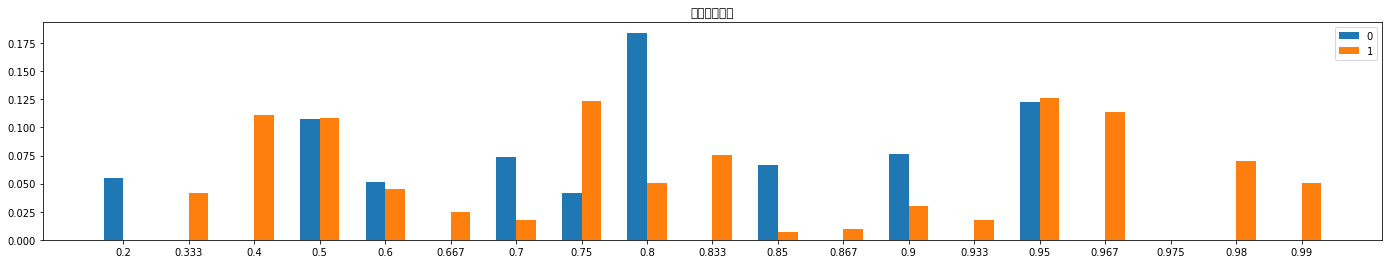

In [284]:
width = 0.3
pt = width/2.


dfthis0.loc[:,'rate0'] =dfthis0['1']/dfthis0['discount_rate'] 
dfthis1.loc[:,'rate1'] =dfthis1['1']/dfthis1['discount_rate'] 
dfthis2 = pd.concat([dfthis1,dfthis0],axis=1)
plt.figure(figsize=(24,4))
xticks = range(0,len(dfthis2))
plt.bar(np.array(xticks)-pt,dfthis2.rate0,width=width,label='0')
plt.bar(np.array(xticks)+pt,dfthis2.rate1,width=width,label='1')
plt.legend()
plt.title(u'各折扣响应率')
plt.xticks(xticks,dfthis2.index);

当type=0，打0.8折时反馈的最多。为什么这个折扣反馈的最多？
且，当两种折扣一致时，只要是type=0的折扣，除了0.75折，反馈率都要高于type2.

 ## 2.2 discount_rate

In [219]:
si_vc = dfall.discount_rate.value_counts().sort_index()
dfthis = pd.DataFrame(si_vc)
cc2 = dfall.groupby('discount_rate')['label'].value_counts()
dfthis.loc[:,'0'] = cc2.xs(0,level=1)
dfthis.loc[:,'1'] = cc2.xs(1,level=1)
dfthis.fillna(0,inplace=True)
dfthis.index = np.around(dfthis.index,3)
dfthis.index = dfthis.index.astype('str')



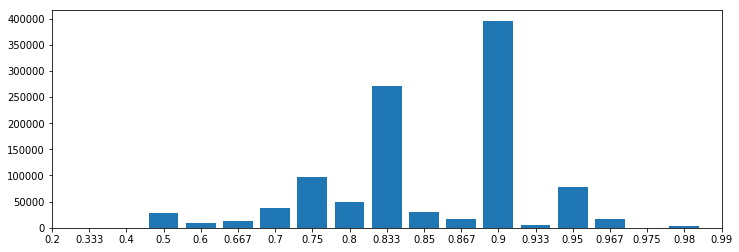

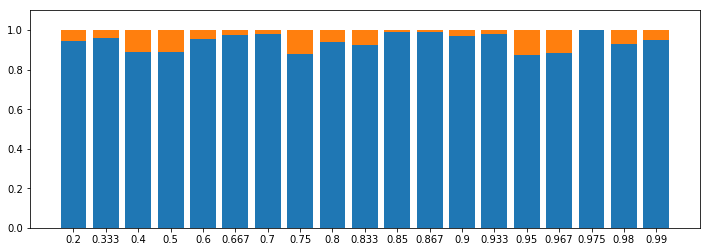

In [218]:
plt.figure(figsize=(12,4))
plt.bar(dfthis.index,dfthis.discount_rate,width=0.8)
plt.xlim(0,1)
plt.xticks(range(0,len(dfthis)),dfthis.index)

plt.figure(figsize=(12,4))
plt.bar(dfthis.index,dfthis['0']/dfthis.discount_rate,width=0.8)
plt.bar(dfthis.index,dfthis['1']/dfthis.discount_rate,width=0.8,bottom=dfthis['0']/dfthis.discount_rate)
plt.ylim(0,1.1)
plt.xticks(dfthis.index);